In [5]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class CatsAndDogsDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        """
        Args:
            image_dir (str): Path to the directory containing images.
            label_dir (str): Path to the directory containing label files.
            transform (callable, optional): Optional transform to be applied to images.
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")
        
        # Load labels
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])
        with open(label_path, 'r') as file:
            labels = file.readlines()
        
        boxes = []
        class_labels = []
        for label in labels:
            label_data = label.strip().split()
            cls = int(label_data[0])  # Class label
            xc, yc, w, h = map(float, label_data[1:])
            
            # Convert YOLO format to (x_min, y_min, x_max, y_max)
            x_min = xc - w / 2
            y_min = yc - h / 2
            x_max = xc + w / 2
            y_max = yc + h / 2
            
            boxes.append([x_min, y_min, x_max, y_max])
            class_labels.append(cls)
        
        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        class_labels = torch.tensor(class_labels, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': class_labels
        }

        if self.transform:
            image = self.transform(image)

        return image, target

In [6]:
import os
data_dir = "Fire-detection-v3-6/"
os.listdir(data_dir)

['data.yaml',
 'README.dataset.txt',
 'README.roboflow.txt',
 'test',
 'train',
 'valid']

In [7]:
train_image_dir = data_dir + "train/images"
train_labels_dir = data_dir + "train/labels"

In [8]:
from torchvision import transforms
image_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

train_dataset = CatsAndDogsDataset(image_dir=train_image_dir, label_dir=train_labels_dir, transform=image_transform)

In [13]:
image, target = train_dataset[100]
image.shape, target['boxes'].shape

(torch.Size([3, 640, 640]), torch.Size([1, 4]))

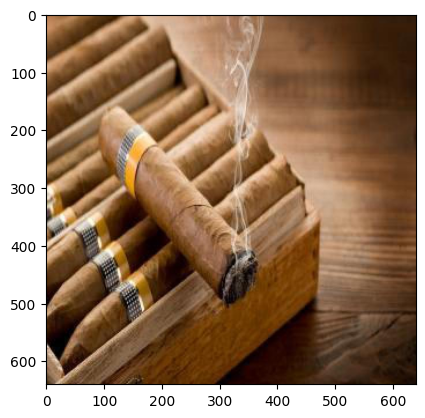

In [14]:
import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0))

In [15]:
target['boxes']

tensor([[0.4477, 0.0094, 0.5977, 0.6969]])

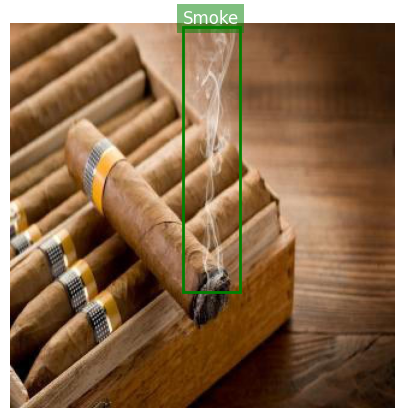

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(image: torch.Tensor, boxes: torch.Tensor, labels: torch.Tensor, class_names: list[str]=None)->None:
    """
    Plots an image with its bounding boxes and class labels.
    
    Args:
        image (torch.Tensor or np.ndarray): The image tensor of shape [C, H, W] or a NumPy array.
        boxes (torch.Tensor or np.ndarray): Bounding boxes in the format [x_min, y_min, x_max, y_max].
        labels (torch.Tensor or np.ndarray): Class labels corresponding to the bounding boxes.
        class_names (list, optional): List of class names for labeling. If None, numeric labels will be used.
    """
    
    # Convert image to [H, W, C] format if it's a tensor
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    
    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(5, 5))
    ax.imshow(image)
    
    # Plot each bounding box
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        
        # Create a rectangle patch
        rect = patches.Rectangle(
            (x_min * image.shape[1], y_min * image.shape[0]),  # Convert relative to absolute coordinates
            width * image.shape[1],
            height * image.shape[0],
            linewidth=2,
            edgecolor='green',
            facecolor='none'
        )
        
        # Add the rectangle to the plot
        ax.add_patch(rect)
        
        # Add class label text
        label = class_names[labels[i]] if class_names else str(labels[i])
        ax.text(
            x_min * image.shape[1],
            y_min * image.shape[0] - 5,
            label,
            color='white',
            fontsize=12,
            bbox=dict(facecolor='green', alpha=0.5, edgecolor='none')
        )
    
    plt.axis("off")
    plt.show()
    
class_names = ['Fire' , 'Smoke']
plot_image_with_boxes(image, target["boxes"], target['labels'],class_names)

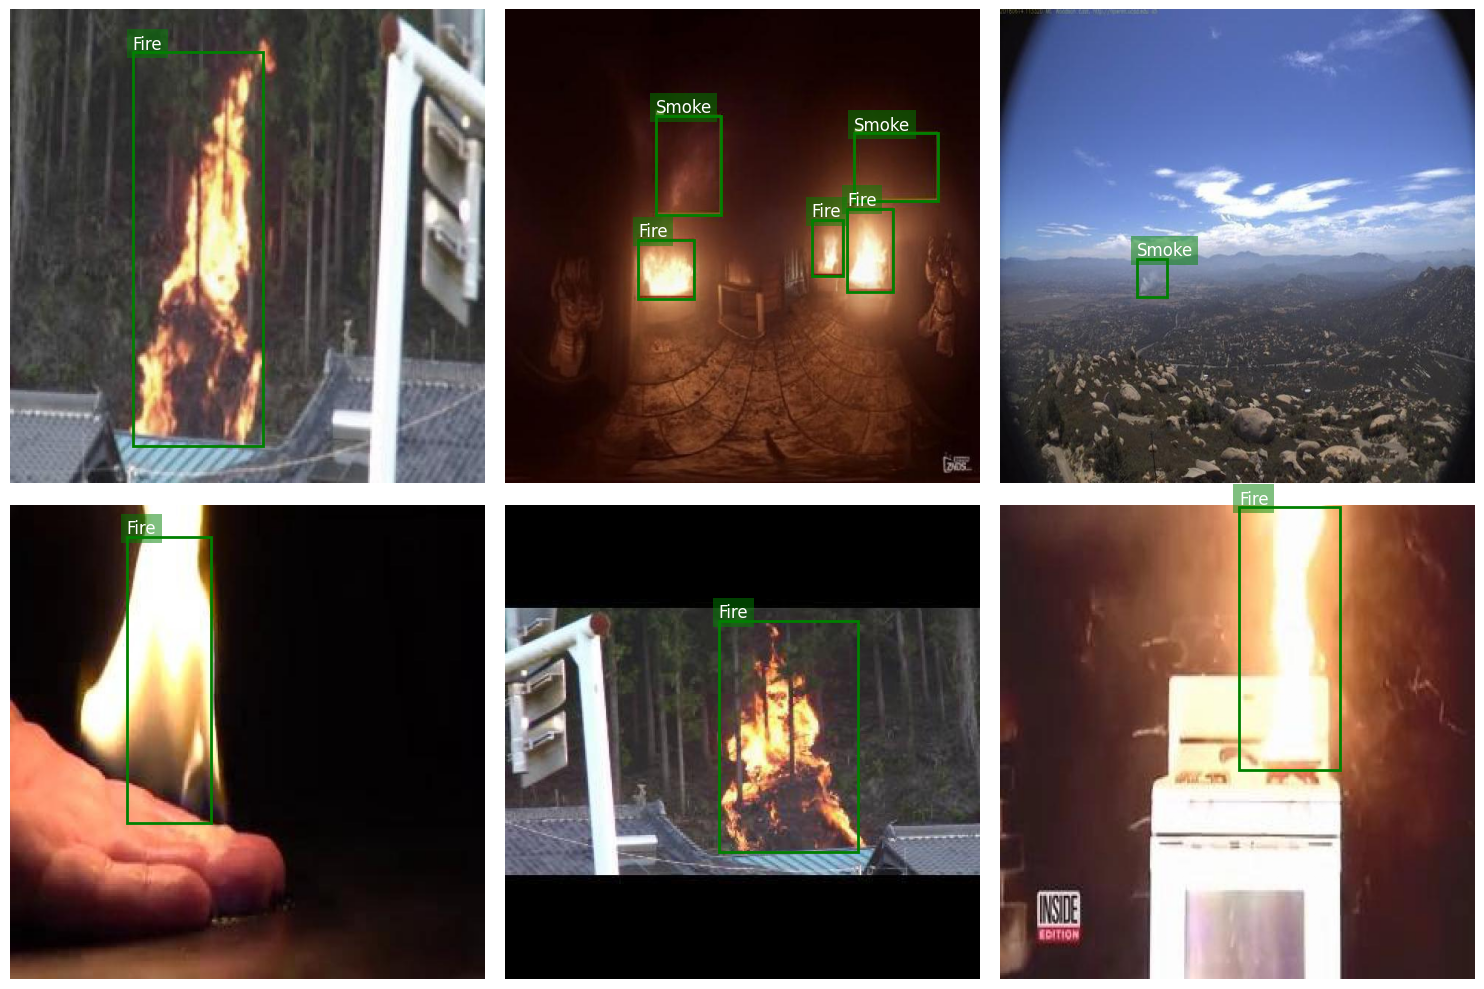

In [17]:
import random
import matplotlib.pyplot as plt

def plot_imagegrid_with_boxes(dataset: torch.utils.data.Dataset, n_rows: int, n_cols: int, class_names: list[str]=None):
    """
    Plots a grid of images with bounding boxes and labels from the given dataset.
    
    Args:
        dataset (torch.utils.data.Dataset): The dataset containing images and bounding boxes.
        plot_image_with_boxes (function): The function to plot an image with its bounding boxes.
        n_rows (int): Number of rows in the grid.
        n_cols (int): Number of columns in the grid.
        class_names (list, optional): List of class names for labeling. If None, numeric labels will be used.
    """
    # Total images to plot
    n_images = n_rows * n_cols
    selected_indices = random.sample(range(len(dataset)), n_images)

    # Create a figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.ravel()  # Flatten the 2D array of axes for easy indexing

    for idx, ax in zip(selected_indices, axes):
        # Get image and target from the dataset
        image, target = dataset[idx]
        boxes = target['boxes']
        labels = target['labels']

        # Convert image tensor to numpy for matplotlib
        image_np = image.permute(1, 2, 0).numpy()

        # Plot the image with bounding boxes
        ax.imshow(image_np)
        ax.axis("off")
        for i, box in enumerate(boxes):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min

            # Convert relative to absolute coordinates
            rect = plt.Rectangle(
                (x_min * image_np.shape[1], y_min * image_np.shape[0]),
                width * image_np.shape[1],
                height * image_np.shape[0],
                linewidth=2,
                edgecolor='green',
                facecolor='none'
            )
            ax.add_patch(rect)

            # Add class label
            label = class_names[labels[i]] if class_names else str(labels[i])
            ax.text(
                x_min * image_np.shape[1],
                y_min * image_np.shape[0] - 5,
                label,
                color='white',
                fontsize=12,
                bbox=dict(facecolor='green', alpha=0.5, edgecolor='none')
            )

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_imagegrid_with_boxes(train_dataset,2,3,class_names)